## todo:

* fix up lake data loading etc
* resample lake etc
* put into DF, save out, clean up! 

## Preprocessing temperature, lake, GPS data'



* Trimming data to my study perdio bounds, interpolating using pandas.datetime


* Calculating GPS displacement relative to start of my study period


* Correcting relative GPS displacement by subtracting overall pre-drainage velocity from data


* Calculating GPS velocity


* Compiling all aux data into dataframes based on interpolation window, saving to csv








Data from Garcia et al., 2019


Garcia, L., Luttrell, K., Kilb, D., & Walter, F. (2019). Joint geodetic and seismic analysis of surface crevassing near a seasonal glacier-dammed lake at Gornergletscher, Switzerland. Annals of Glaciology, 60(79), 1-13. doi:10.1017/aog.2018.32


https://www.cambridge.org/core/journals/annals-of-glaciology/article/joint-geodetic-and-seismic-analysis-of-surface-crevassing-near-a-seasonal-glacierdammed-lake-at-gornergletscher-switzerland/15E026FE40EB6CA4E3FD5A4B5602E2F2


Tables 6 and 7 from supplement are used.

Download supplementary material:: 

https://static.cambridge.org/content/id/urn:cambridge.org:id:article:S0260305518000320/resource/name/S0260305518000320sup002.pdf






In [1]:

from scipy.io import loadmat

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


plt.rcParams.update({'font.size': 22})
plt.rcParams["figure.figsize"] = (22,10)


## functions

In [2]:

    
def extractStationName(gpsdata, column_number=1):
    '''
    
    '''
            

    n=0
    data_list = []
    
    while n < len(gpsdata[column_number][:]):
        
        try:
            data = gpsdata[column_number][n][0]
            data_list.append(data)
            print(data)
            n = n + 1
    
        except:
            break

            
    return data_list



def trimGPS(gps_disp,gps_jday,doy1=165,doy2=205):
    
    gps_jday_trim = []    
    gps_disp_trim = []
        
    for i in range(0,4): ##skip last station, station#44

        gps_jday_0 = gps_jday[i][gps_jday[i]>=doy1]
        gps_jday_00 = gps_jday_0[gps_jday_0<doy2]



        gps_disp_0 = gps_disp[i][gps_jday[i]>=doy1]
        gps_disp_00 = gps_disp_0[gps_jday_0<doy2]
        
        gps_jday_trim.append(gps_jday_00)
        gps_disp_trim.append(gps_disp_00)    
        

    
    
    return gps_jday_trim, gps_disp_trim


    
    

def calcRelativeGPSDisp(gps_disp_trim,gps_jday_trim,startDoy = 165):
    
### From Lutrell/Garcia's matlab code    
### plot(  GPS_disp.jday  ,   GPS_disp.dis  -    [ ones(length(GPS_disp.t),1)  *  GPS_disp.dis_on_day155   ]
    
    
    relDisp_list = []
    
    for i in range(0,4):
        disp    = gps_disp_trim[i]
        GPS_disp_on_day165 = disp[np.argwhere(gps_jday_trim[i]==165)[0][0]]
        relDisp = disp - (np.ones(len(disp)) * GPS_disp_on_day165)
        relDisp_list.append(relDisp)

    
    return relDisp_list


def correctGPS(gps_jday_trim,relDisp_list,m):


    correct_GPS_list = []
    for i in range(0,4):
        

        day_vector = gps_jday_trim[i] - np.min(gps_jday_trim[i]) 

        slope = day_vector * m[i]

        correct_GPS = relDisp_list[i] - slope
        
        correct_GPS_list.append(correct_GPS)
        
        
    return correct_GPS_list

### Load data

In [3]:


pathIn = './Bundled_data_2007.mat'
pathOut = './preprocessed_data/'


mat = loadmat(pathIn)


keys_list = mat.keys()

for keys in mat.keys():
    print(keys)
    exec(f"var_{keys} = mat.get('{keys}')")



name_list = [[row.flat[0] for row in line] for line in mat['GPS_disp'][0][0]]

year = mat['GPS_disp'][0][0][0]
station = extractStationName(name_list, column_number=1)
t = mat['GPS_disp'][0][0][2]
jday = mat['GPS_disp'][0][0][3]
x = mat['GPS_disp'][0][0][4]
y = mat['GPS_disp'][0][0][5]
z = mat['GPS_disp'][0][0][6]
dis = mat['GPS_disp'][0][0][7]
dis_on_day_155 = mat['GPS_disp'][0][0][8]

__header__
__version__
__globals__
GPS_disp
LakeLevel
Meteor
Outlines
Strain_East
Strain_Mid
Strain_West
Station #24
Station #34
Station #36
Station #37
Station #44


# Basic data exploration

What is sampling rate, what are data bounds...

In [4]:
gps_disp = []
gps_jday = []


doy1=165
doy2=204

for i in range(0,4):
    
    
    
    gps_jday.append(jday[:,i])

#     gps_disp.append(dis[:,i])
    gps_disp.append(z[:,i])

In [5]:
for i in range(0,4):
    

    avg_dt = np.nanmean(np.diff(gps_jday[i]))
    avg_dt_sec = avg_dt * 60*60*24
    doy_0 = np.nanmin(jday[:,i])
    
    
    print(station[i])    
    print(f'Earliest datapoint: DOY {doy_0:.3f}')
    print(f'Sampling rate for GPS: {avg_dt:.4f} days ({avg_dt_sec:.4f} sec) \n')
    

Station #24
Earliest datapoint: DOY 115.553
Sampling rate for GPS: 0.0020 days (172.4711 sec) 

Station #34
Earliest datapoint: DOY 115.553
Sampling rate for GPS: 0.0015 days (132.5771 sec) 

Station #36
Earliest datapoint: DOY 115.553
Sampling rate for GPS: 0.0015 days (129.6610 sec) 

Station #37
Earliest datapoint: DOY 115.553
Sampling rate for GPS: 0.0015 days (128.3991 sec) 



# GPS

## plot raw GPS

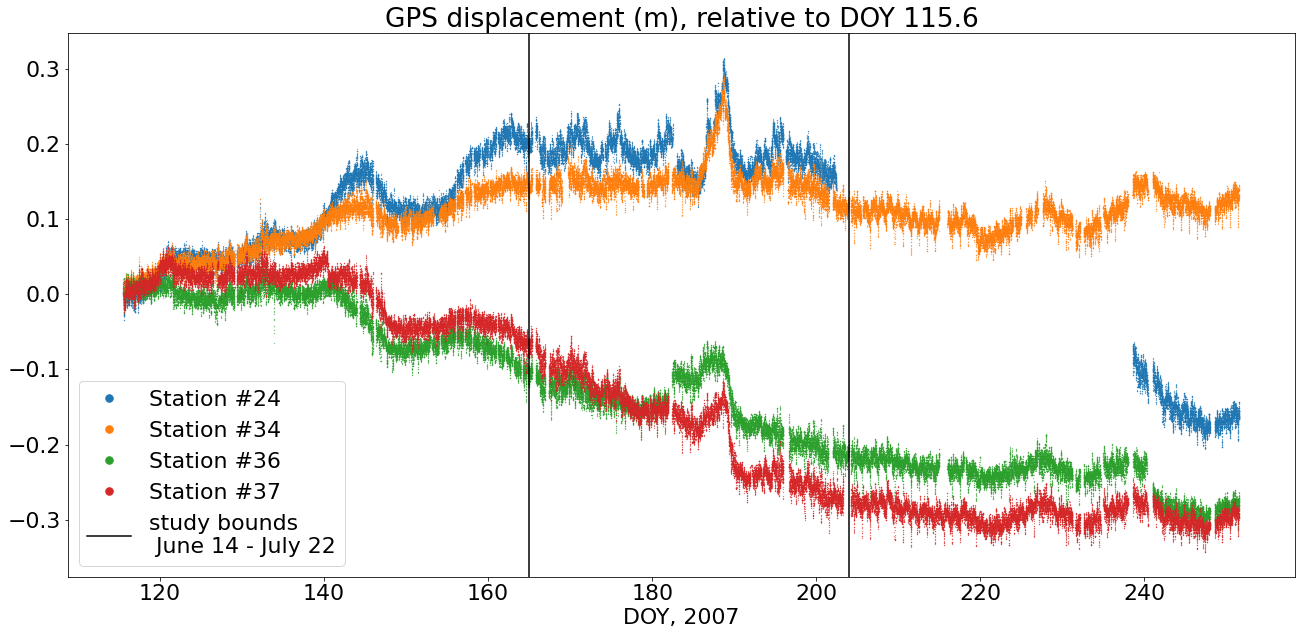

In [6]:



for i in range(0,4):

    plt.plot(gps_jday[i],gps_disp[i],label=station[i],ls='None',marker='.',ms=.5)
    
    ax = plt.gca()

ax.set_title(f'GPS displacement (m), relative to DOY {doy_0:.1f}')
ax.set_xlabel('DOY, 2007')

### my study period
ax.axvline(x=doy1,color='k',label='study bounds \n June 14 - July 22')
ax.axvline(x=doy2,color='k')

ax.legend(markerscale=30);


## Trim GPS

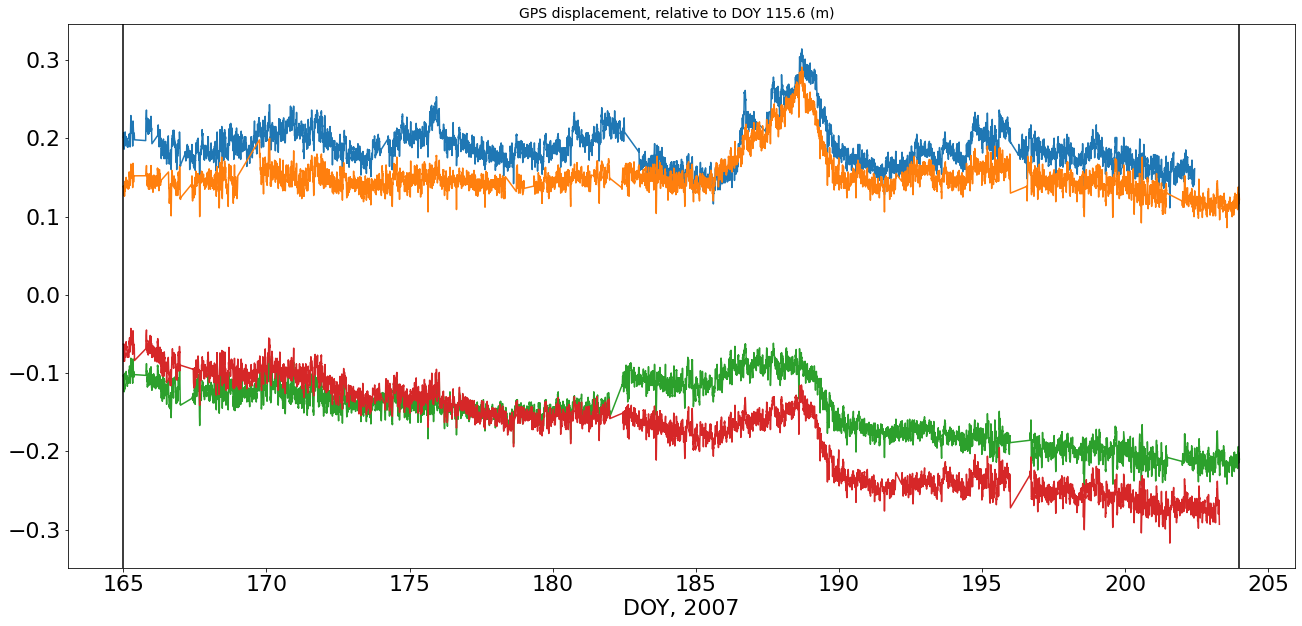

In [7]:



gps_jday_trim, gps_disp_trim = trimGPS(gps_disp,gps_jday,doy1=doy1,doy2=doy2)


for i in range(0,4):
    plt.plot(gps_jday_trim[i],gps_disp_trim[i])
    
plt.xlabel('DOY, 2007')
plt.title(f'GPS displacement, relative to DOY {doy_0:.1f} (m)  ',fontsize=14)


ax = plt.gca()
### my study period
ax.axvline(x=doy1,color='k')
ax.axvline(x=doy2,color='k')



### calc displacement relative to starttime 

In [8]:
relDisp_list = calcRelativeGPSDisp(gps_disp_trim,gps_jday_trim,startDoy = doy1)

Text(0.5, 0, 'DOY, 2007')

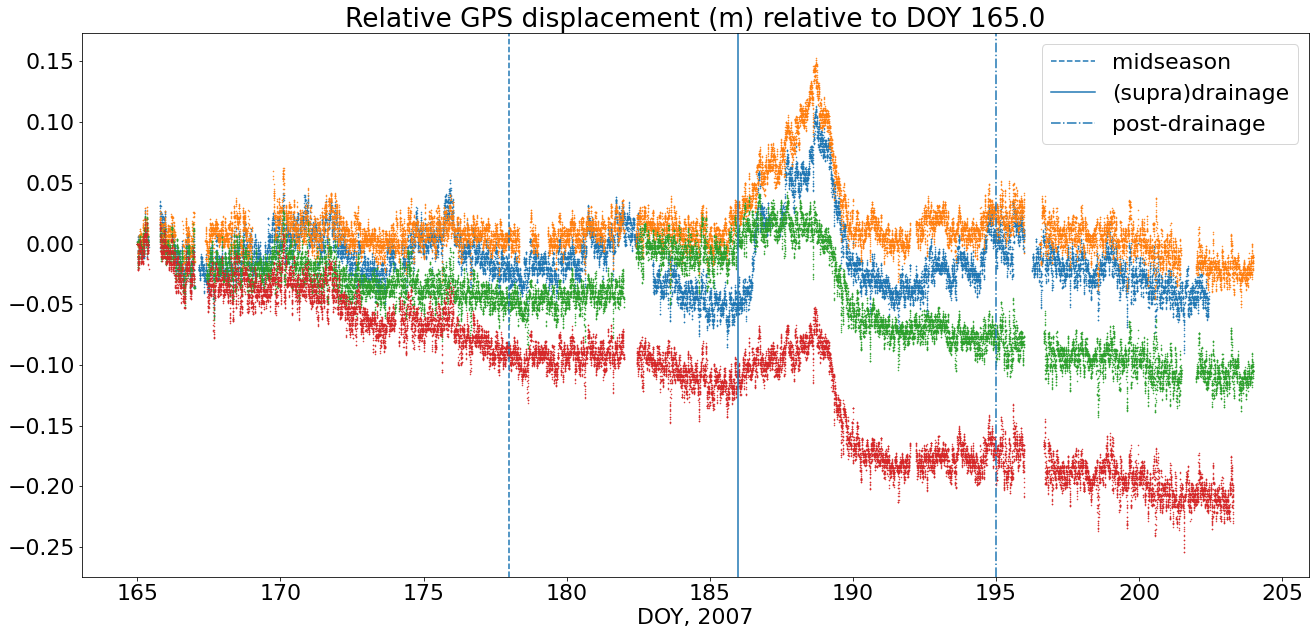

In [9]:

for i in range(0,4):

    plt.plot(gps_jday_trim[i],relDisp_list[i],ls='None',marker='.',ms=1)
    

    
ax = plt.gca()

##timings from table S6

ax.axvline(x=178,label='midseason',ls='--')
ax.axvline(x=186,label='(supra)drainage',ls='-')
ax.axvline(x=195,label='post-drainage',ls='-.')

plt.legend()

plt.title(f'Relative GPS displacement (m) relative to DOY {doy1:.1f}')
plt.xlabel('DOY, 2007')

## Corrected relative displacement

Text(0.5, 0, 'DOY, 2007')

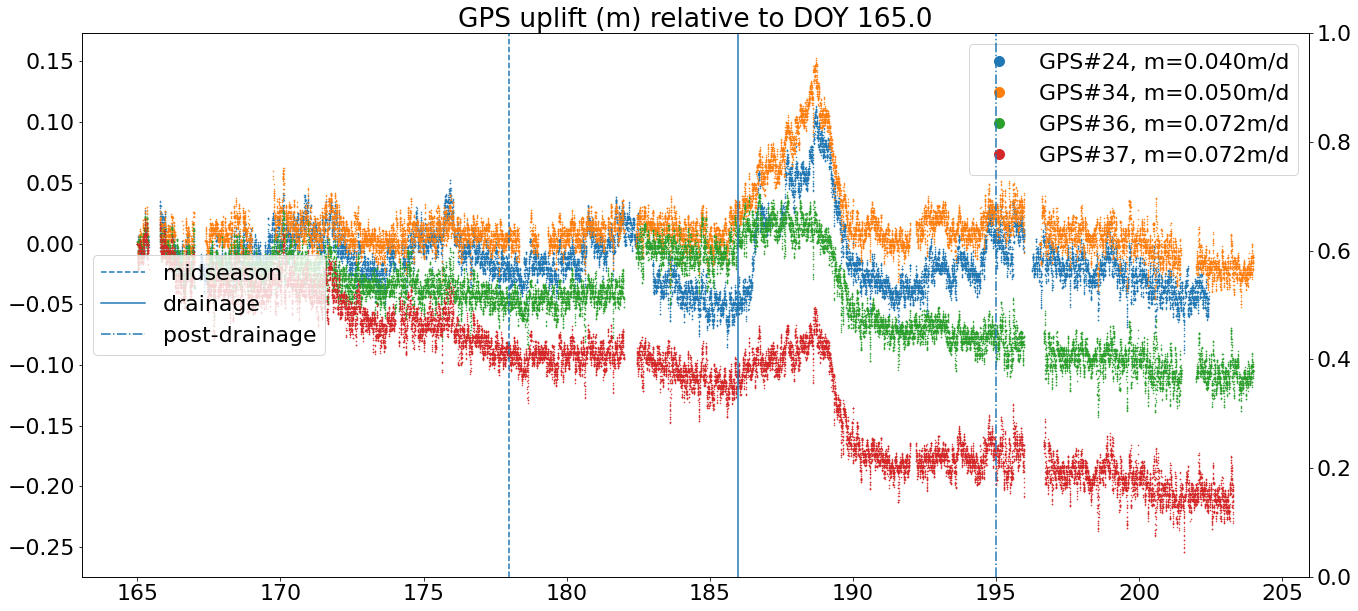

In [23]:

for i in range(0,4):

    plt.plot(gps_jday_trim[i],
             relDisp_list[i],
             ls='None',
             marker='.',
             ms=1,
            label=f'GPS{station[i][-3:]}, m={m[i]:.3f}m/d')
    

plt.legend(markerscale=20)
    
ax0 = plt.gca()

##timings from table S6
ax = ax0.twinx()
ax.axvline(x=178,label='midseason',ls='--')
ax.axvline(x=186,label='drainage',ls='-')
ax.axvline(x=195,label='post-drainage',ls='-.')

ax.legend(loc='center left')

plt.title(f'GPS uplift (m) relative to DOY {doy1:.1f}')
plt.xlabel('DOY, 2007')

# Resample and put into dataframes, calc secondary products


See: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html


Binning labeled by left value


## Convert DOY to pandas datetime objects

In [14]:

gps_datetime = []
gps_datetime_index = []

for i in range(0,4):
    
    gps_datetime_i = pd.to_datetime('2006-12-31') + pd.to_timedelta(gps_jday_trim[i], unit='D')
    gps_datetime_ind = pd.to_datetime('2006-12-31') + pd.to_timedelta(gps_jday_trim[i], unit='D')
    
    gps_datetime.append(gps_datetime_i)
    gps_datetime_index.append(gps_datetime_ind)


gps_df_list = []

for i in range(0,4):
    
    gps_dfi = pd.DataFrame({'datetime_index':gps_datetime_index[i],
                            'datetime':gps_datetime[i],
                            'gps_relDispFromDOY165_m':relDisp_list[i],
                            'gps_relDispFromDOY165Corrected_m':correct_GPS_list[i]})

    gps_dfi = gps_dfi.set_index('datetime_index')
    
    
    gps_df_list.append(gps_dfi)

# Imputation -- how to fill missing values

replace nans with whatever was the earlier value (pad=ffill, forward fill) or whatever is next value (bfill, backfill)

## Sum or mean? What's going on here ith the summing???


In the hour-bin starting with the left label, the glacier moves X m. We may expand the binsize, but we care about the average motion in that bin size, not the sum (that would be velocity). 

It's gotta be the mean value -- that's what matches Garcia et al

In [15]:
# # sumH = gps_df_list[0].resample('H', label='right', closed='right').sum()
# # meanH = gps_df_list[0].resample('H', label='right', closed='right').mean()
# # sum3H = gps_df_list[0].resample('3H', label='right', closed='right').sum()
# # mean3H = gps_df_list[0].resample('3H', label='right', closed='right').mean()

# # sumH.gps_relDispFromDOY165_m

# plt.figure()
# plt.plot(sumH.gps_relDispFromDOY165_m,ls='-',marker='.',ms=4)
# plt.figure()
# plt.plot(meanH.gps_relDispFromDOY165_m,ls='None',marker='.',ms=5)
# plt.figure()
# plt.plot(sum3H.gps_relDispFromDOY165_m,ls='None',marker='.',ms=5)
# plt.figure()
# plt.plot(mean3H.gps_relDispFromDOY165_m,ls='None',marker='.',ms=5)
# plt.figure()

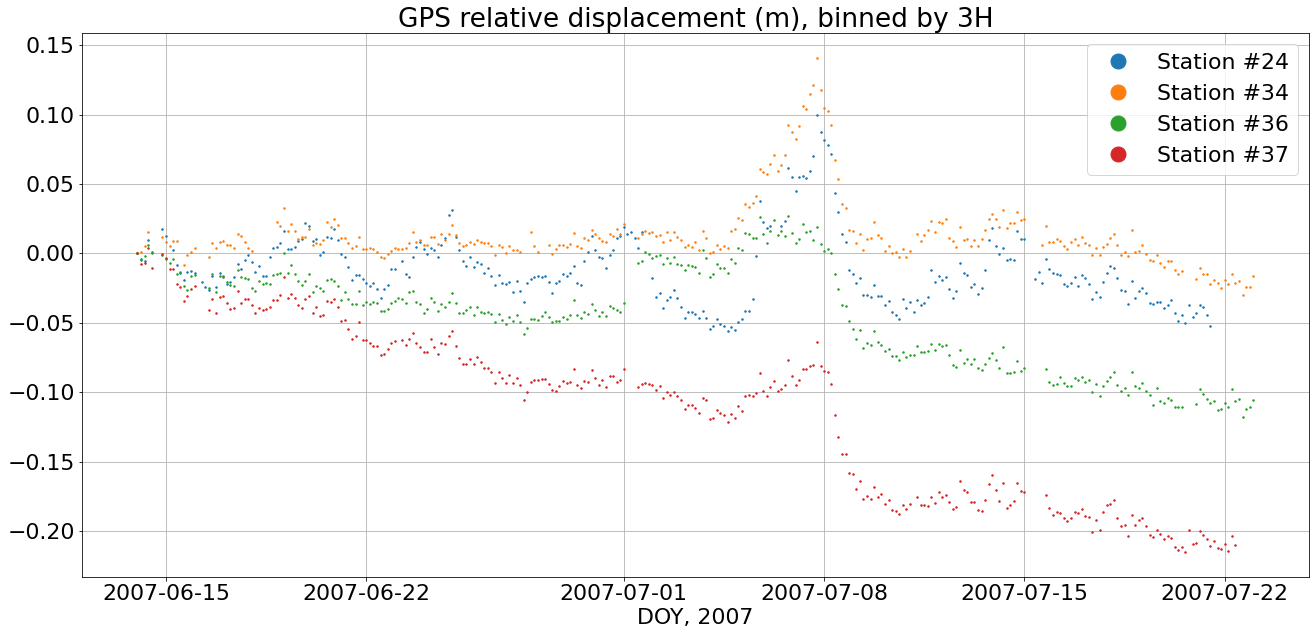

In [25]:
#resample by mean of values in bin, labeled by the earliest value 

bin_length = '3H'

gps_resampled_list = []
gps_resampled_corr_list = []

for i in range(0,4):
    gps_resampled = gps_df_list[i].gps_relDispFromDOY165_m.resample(bin_length, label='right', closed='right').mean()
    gps_resampled_corr = gps_df_list[i].gps_relDispFromDOY165Corrected_m.resample(bin_length, label='right', closed='right').mean()    
    gps_resampled_list.append(gps_resampled)
    gps_resampled_corr_list.append(gps_resampled_corr)


    plt.plot(gps_resampled,ls='None',marker='.',ms=3,label=station[i])
    
plt.grid('on')
plt.title(f'GPS relative displacement (m), binned by {bin_length}')
plt.xlabel('DOY, 2007')
plt.legend(markerscale=10)

# ##timings from table S6
# ax0 = plt.gca()
# ax = ax0.twinx()
##agh convert to datetime
# ax.axvline(x=178,label='midseason',ls='--')
# ax.axvline(x=186,label='drainage',ls='-')
# ax.axvline(x=195,label='post-drainage',ls='-.')

ax.legend(loc='center left')

## calc Velocity and Accel

In [17]:

# #% calc vel and accel
    
    
# for gs in gpsstations:
#     exec(f"staaa = {'gps' + str(gs)}")
    


#     dt = np.diff(staaa.datetime2)*1e-9 #s
#     dt = [int(dd) for dd in dt]

    
#     vel = np.diff(staaa.corrected_cm) / dt #m/s  
#     vel = np.insert(vel,0,np.nan)
    
    
#     accel = np.diff(vel) / dt #m/s/s
    
    
#     dt = np.insert(dt,0,0)    
#     accel = np.insert(accel,0,0)        



#     staaa['dtS'] = dt
#     staaa['velMperS'] = vel
#     staaa['accelMperSperS'] = accel
    
    
#     exec(f"{'gps' + str(gs)} = staaa")
    

    

## Lake Level

In [18]:
#%% format data

lake_data = [[row.flat[0] for row in line] for line in mat['LakeLevel'][0][0]]


lake_m = list(lake_data[0])
lake_doy = list(lake_data[4])



## Temperature and Precipiatation

In [19]:

#%%temp
  

temp_doy = mat['Meteor'][0][2][1][:,0]

temp_data = mat['Meteor'][0][2][2][:,0]


rain_data = mat['Meteor'][0][2][3][:,0]



# [t.set_color('r') for t in ax.yaxis.get_ticklabels()]



# Combine into DF for each dataset and resample

In [21]:
lake_datetime = pd.to_datetime('2006-12-31',  format='%Y-%m-%d') + pd.to_timedelta(lake_doy, unit='D')
lake_datetime2 = pd.to_datetime('2006-12-31',  format='%Y-%m-%d') + pd.to_timedelta(lake_doy, unit='D')

temp_datetime = pd.to_datetime('2006-12-31') + pd.to_timedelta(temp_doy, unit='D')
temp_datetime2 = pd.to_datetime('2006-12-31') + pd.to_timedelta(temp_doy, unit='D')


In [22]:
lake_df = pd.DataFrame({'lake':lake_m,
                         'doy':lake_doy,
                       'datetime':lake_datetime2},
                       index=lake_datetime)


meteor_df = pd.DataFrame({'temp':temp_data,
                         'rain':rain_data,
                         'doy':temp_doy,
                       'datetime':temp_datetime2},
                         index=temp_datetime)

    

## Trim to study bounds

In [ ]:
lake_df_0 = lake_df.where(lake_df.doy>=doy1)
lake_df_00 = lake_df_0.where(lake_df_0.doy<doy2).dropna()

meteor_df_0 = meteor_df.where(meteor_df.doy>=doy1)
meteor_df_00 = meteor_df_0.where(meteor_df_0.doy<doy2).dropna()

## resample

In [ ]:
lake_H = lake_df_00.resample('H', label='right', closed='right').mean()
lake_3H = lake_df_00.resample('3H', label='right', closed='right').mean()
lake_3T = lake_df_00.resample('3T', label='right', closed='right').mean()
lake_D = lake_df_00.resample('D', label='right', closed='right').mean()

meteor_H = meteor_df_00.resample('H', label='right', closed='right').mean()
meteor_3H = meteor_df_00.resample('3H', label='right', closed='right').mean()
meteor_3T = meteor_df_00.resample('3T', label='right', closed='right').mean()
meteor_D = meteor_df_00.resample('D', label='right', closed='right').mean()




In [ ]:
f'gps{station[i][-2:]}_relDisp_m_{bin_length}'

In [ ]:
gps_df_list[i].gps_relDispFromDOY165Corrected_m

In [ ]:
#resample by mean of values in bin, labeled by the earliest value 

bin_length = '3T'

gps_resampled_list = []

for i in range(0,4):
    exec(f"gps{station[i][-2:]}_relDispCorr_m_{bin_length} = gps_df_list[i].gps_relDispFromDOY165Corrected_m.resample(bin_length, label='right', closed='right').mean()")
    exec(f"gps{station[i][-2:]}_relDisp_m_{bin_length} = gps_df_list[i].gps_relDispFromDOY165_m.resample(bin_length, label='right', closed='right').mean()")
    
    
    print(f"gps{station[i][-2:]}_relDisp_m_{bin_length}, gps{station[i][-2:]}_relDispCorr_m_{bin_length}")

## combine into dataframe

In [ ]:
garciaDF_D = pd.DataFrame({'lake_D':lake_D.lake,
                            'temp_D':meteor_D.temp,
                            'rain_D':meteor_D.rain,
                           
                            'gps24_D':gps24_relDisp_m_D,
                            'gps34_D':gps34_relDisp_m_D,
                            'gps36_D':gps36_relDisp_m_D,
                            'gps37_D':gps37_relDisp_m_D,

                            'gps24_D':gps24_relDispCorr_m_D,
                            'gps34_D':gps34_relDispCorr_m_D,
                            'gps36_D':gps36_relDispCorr_m_D,
                            'gps37_D':gps37_relDispCorr_m_D}
                            )

garciaDF_3H = pd.DataFrame({'lake_3H':lake_3H.lake,
                            'temp_3H':meteor_3H.temp,
                            'rain_3H':meteor_3H.rain,
                            'gps24_3H':gps24_relDisp_m_3H,
                            'gps34_3H':gps34_relDisp_m_3H,
                            'gps36_3H':gps36_relDisp_m_3H,
                            'gps37_3H':gps37_relDisp_m_3H,
                            'gps24_3H':gps24_relDispCorr_m_3H,
                            'gps34_3H':gps34_relDispCorr_m_3H,
                            'gps36_3H':gps36_relDispCorr_m_3H,
                            'gps37_3H':gps37_relDispCorr_m_3H}
                            )



garciaDF_H = pd.DataFrame({'lake_H':lake_H.lake,
                            'temp_H':meteor_H.temp,
                            'rain_H':meteor_H.rain,
                            'gps24_H':gps24_relDisp_m_H,
                            'gps34_H':gps34_relDisp_m_H,
                            'gps36_H':gps36_relDisp_m_H,
                            'gps37_H':gps37_relDisp_m_H,
                            'gps24_H':gps24_relDispCorr_m_H,
                            'gps34_H':gps34_relDispCorr_m_H,
                            'gps36_H':gps36_relDispCorr_m_H,
                            'gps37_H':gps37_relDispCorr_m_H}
                            )




garciaDF_3T = pd.DataFrame({'lake_3T':lake_3T.lake,
                            'temp_3T':meteor_3T.temp,
                            'rain_3T':meteor_3T.rain,
                            'gps24_3T':gps24_relDisp_m_3T,
                            'gps34_3T':gps34_relDisp_m_3T,
                            'gps36_3T':gps36_relDisp_m_3T,
                            'gps37_3T':gps37_relDisp_m_3T,
                            'gps24_3T':gps24_relDispCorr_m_3T,
                            'gps34_3T':gps34_relDispCorr_m_3T,
                            'gps36_3T':gps36_relDispCorr_m_3T,
                            'gps37_3T':gps37_relDispCorr_m_3T}
                            )


## save csv

In [ ]:
pwd

In [ ]:
garciaDF_H.to_csv('./garciaDF_H.csv')
garciaDF_3H.to_csv('./garciaDF_3H.csv')
garciaDF_D.to_csv('./garciaDF_D.csv')
# garciaDF_3T.to_csv('./garciaDF_3T.csv')